# Code for competition

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import shutil
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from PIL import Image
import zipfile

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Enable experimental feature of memory occupation growth control 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Metadata

In [2]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
batch_size = 64
epochs = 400
classes = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Prepare the environment

In [3]:
train_split = 0.85

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path 
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)
    
        class_source = source + '/' + folder                                                   # Create path of the class
        files = os.listdir(class_source)                                                       # List of files for the class
        random.shuffle(files)                                                                  # Split is performed randomly
        
        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            dest = shutil.copy(class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])  # Copy an image in the training set
        
        # Create validation set randomly
        for j in range(i + 1, len(files)):
            dest = shutil.copy(class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])  # copy an image in the validation set

### Preprocessing function

In [4]:
def preprocessing(image):
    return tf.image.adjust_saturation(image, 3)

### Prepare the validation set for evaluation purposes

In [5]:
samples = []
targets = []

dest_valid = os.getcwd() + '/validation'

i=0
for folder in os.listdir(dest_valid):
    dest_class = dest_valid + '/' + folder
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = preprocessing(np.squeeze(np.expand_dims(temp, axis=0)) / 255.)
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
    i += 1

X_val = np.array(samples)
y_val = np.array(targets, dtype=np.uint8)
print(X_val.shape, X_val.dtype, sep=", ")
print(y_val.shape, y_val.dtype, sep=", ")

(535, 96, 96, 3), float64
(535, 8), uint8
{0: 2.388392857142857, 1: 0.8359375, 2: 0.8573717948717948, 3: 0.8685064935064936, 4: 0.8359375, 5: 1.9669117647058822, 6: 0.8256172839506173, 7: 0.8685064935064936}


### Prepare the training set for standardization

In [6]:
samples = []
targets = []

dest_train = os.getcwd() + '/training'

i=0
for folder in os.listdir(dest_train):
    dest_class = dest_train + '/' + folder
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
    i += 1
X_train = np.array(samples)
y_train = np.array(targets, dtype=np.uint8)
print(X_train.shape, X_train.dtype, sep=", ")
print(y_train.shape, y_train.dtype, sep=", ")

# Compute the class weights in order to balance loss during training
y_numeric = []
for v in y_train:
    y_numeric.append(np.argmax(v))

labels = np.unique(np.fromiter([np.argmax(t) for t in y_train], np.int32))
    
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))
print(class_weights)

(3007, 96, 96, 3), uint8
(3007, 8), uint8


### Static augmentation (only on training set)

In [7]:
static_aug = True
balanced = False

if static_aug and not os.path.exists(path+'/training_aug'):
    old_train = os.getcwd() + '/training'
    dest_train = os.getcwd() + '/training_aug'
    shutil.copytree(old_train, dest_train)

    desired_amount = 800
    expansion_factor = 200

    static_shift = 10
    static_gen = ImageDataGenerator(rotation_range=180,
                                    width_shift_range=static_shift,
                                    height_shift_range=static_shift,
                                    #channel_shift_range=150,
                                    shear_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='reflect')

    label = 0
    for folder in os.listdir(dest_train):
        dest_path = dest_train + '/' + folder

        if balanced:
            to_produce = desired_amount - len(os.listdir(dest_path))
        else:
            class_expansion = [6., 1., 1., 1., 1., 3., 1., 3]
            to_produce = int(class_expansion[label] * expansion_factor)
        
        static_gen_data = static_gen.flow_from_directory(dest_train,
                                                        batch_size=1,
                                                        target_size=input_size,
                                                        classes=[folder],
                                                        class_mode='categorical',      # Targets are directly converted into one-hot vectors
                                                        shuffle=False,
                                                        seed=seed) 

        print(f'Computing {to_produce} augmented images for target "{folder}"')
        os.chdir(dest_path)
        for i in range(0, to_produce):
            Image.fromarray(np.squeeze(next(static_gen_data)[0]).astype(np.uint8)).save(f'aug{i:05}.jpg')
        os.chdir('../')
        label += 1

    os.chdir('../')
    print('\n' + os.getcwd())

Found 158 images belonging to 1 classes.
Computing 1200 augmented images for target "Species1"
Found 452 images belonging to 1 classes.
Computing 200 augmented images for target "Species2"
Found 437 images belonging to 1 classes.
Computing 200 augmented images for target "Species3"
Found 434 images belonging to 1 classes.
Computing 200 augmented images for target "Species4"
Found 451 images belonging to 1 classes.
Computing 200 augmented images for target "Species5"
Found 188 images belonging to 1 classes.
Computing 600 augmented images for target "Species6"
Found 456 images belonging to 1 classes.
Computing 200 augmented images for target "Species7"
Found 431 images belonging to 1 classes.
Computing 600 augmented images for target "Species8"

c:\Users\tomma\Documents\GitHub\AN2DL-project-2022\Code


### Online augmentation
Lets create the generators we'll need...

In [8]:
shift = 30
train_data_gen = ImageDataGenerator(width_shift_range=shift,
                                    height_shift_range=shift,
                                    #brightness_range=(0.95, 1.05),
                                    #zoom_range=[0.8,1.5],
                                    fill_mode='reflect',
                                    #preprocessing_function=preprocessing,
                                    #featurewise_std_normalization=True,
                                    #featurewise_center=True, 
                                    rescale=1./255
                                    )

valid_data_gen = ImageDataGenerator(#preprocessing_function=preprocessing,
                                    #featurewise_std_normalization=True,
                                    #featurewise_center=True, 
                                    rescale=1./255
                                    )

# Fit the standardization values
#train_data_gen.fit(X_train)
#valid_data_gen.fit(X_train)

... using flow_from_directory

In [9]:
# Paths
path = os.getcwd()
if static_aug:
    training_dir = path + '/training_aug'
else:
    training_dir = path + '/training'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)  

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size, 
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

valid_dataset = valid_dataset.repeat()

Found 6407 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


### Models definition functions

In [10]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.InceptionV3(include_top=False,
                                            weights="imagenet",
                                            input_shape=input_shape)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dropout(0.4, seed=seed, name='dropout')(x)
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-4), metrics='accuracy')

    # Return the model
    return model

### Define the model

In [11]:
model = build_tl_model(input_shape)

model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 gap (GlobalAveragePooling2D  (None, 2048)             0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 output_layer (Dense)        (None, 8)                 16392     
                                                                 
Total params: 21,819,176
Trainable params: 21,784,744
Non-trainable params: 34,432
_________________________________________

### Train the model

In [12]:
train_mul = 1

decay_rate = 5
min_lr = 2e-5

def scheduler(epoch, lr):
    if epoch % decay_rate == (decay_rate - 1):
        return max(lr * tf.math.exp(-0.1), min_lr)
    return lr

history = model.fit(x=train_dataset,
                    epochs=epochs,                                     # Only indicative since we set "repeat" in training and validation datasets
                    steps_per_epoch=int(len(train_gen) * train_mul),
                    validation_data=valid_dataset,
                    validation_steps=len(valid_gen),
                    class_weight=class_weights,
                    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=21, restore_best_weights=True),
                                 tfk.callbacks.LearningRateScheduler(scheduler)]
).history

Epoch 1/400


KeyboardInterrupt: 

### Plot training results

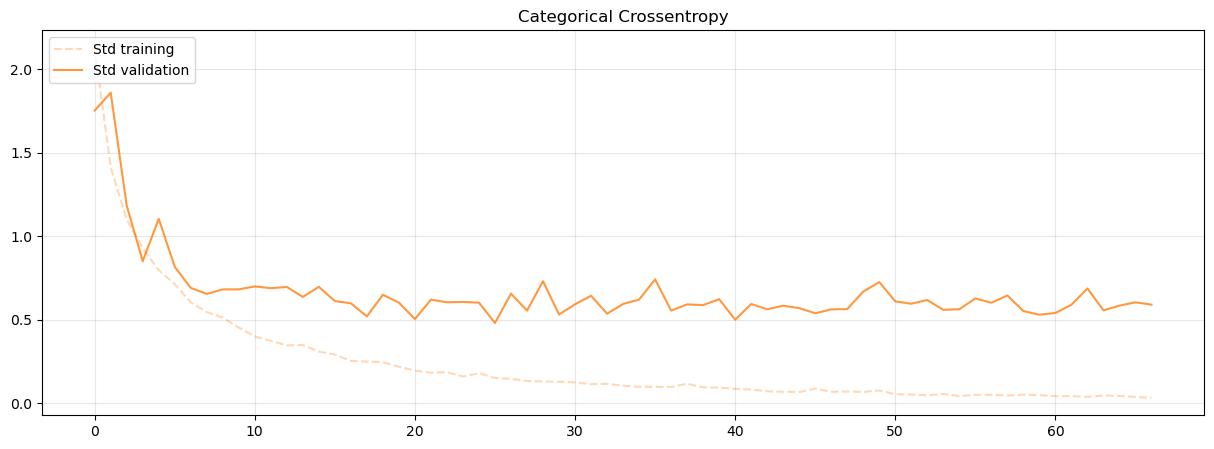

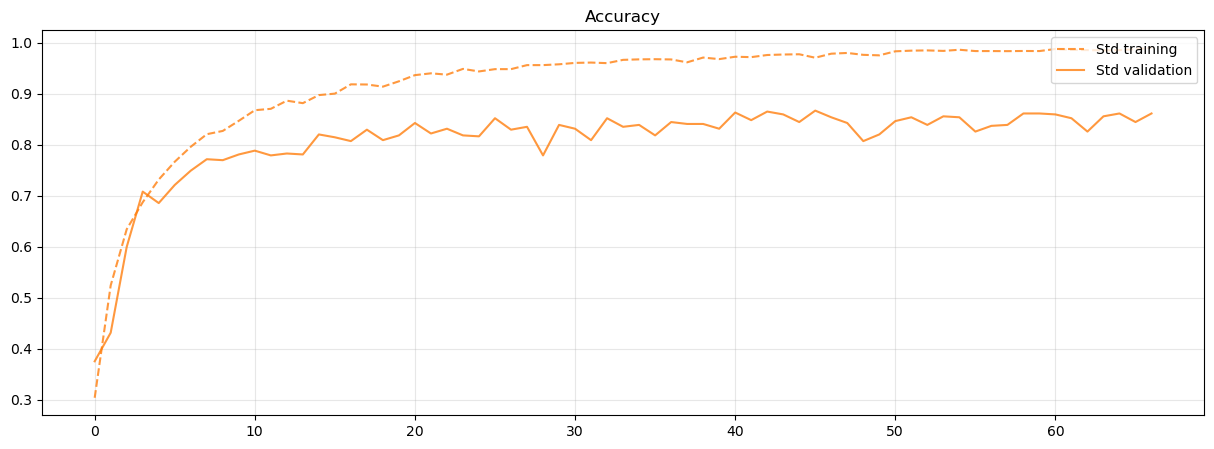

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

9/9 [==============================] - 5s 225ms/step
Accuracy: 0.8673
Precision: 0.8499
Recall: 0.8493
F1: [0.5797 0.8727 0.9299 0.8816 0.9045 0.8571 0.9308 0.8108]


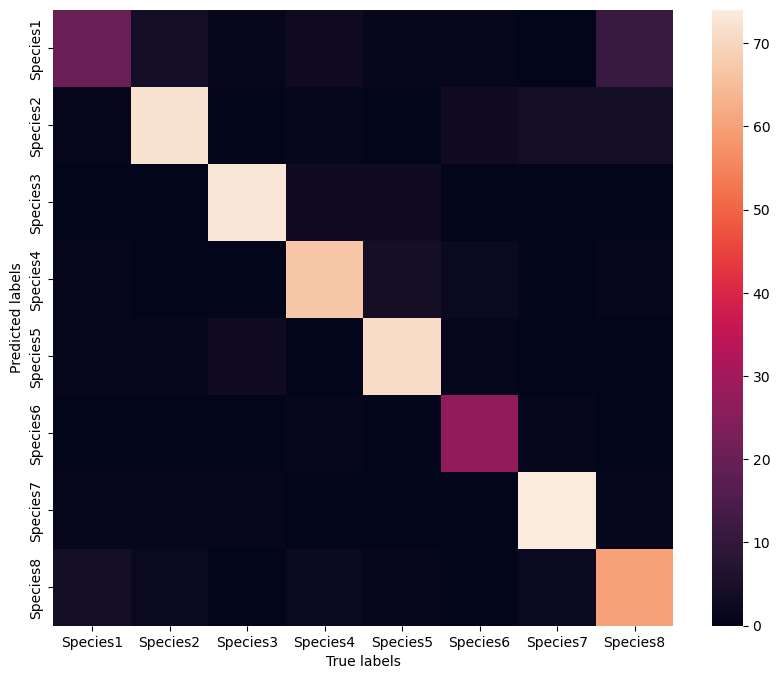

In [ ]:
predictions = model.predict(valid_dataset, steps=len(valid_gen))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Unzip model

In [ ]:
path = os.getcwd()
if not os.path.exists(path+'/best_model'):
    with zipfile.ZipFile('best_model.zip', 'r') as zip_ref:
        zip_ref.extractall('best_model')
    os.remove('best_model.zip')

### Save the model

In [ ]:
restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(valid_dataset, steps=len(valid_gen), verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(valid_dataset, steps=len(valid_gen), verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

9/9 - 5s - loss: 48.9881 - accuracy: 0.1028 - 5s/epoch - 604ms/step
9/9 - 3s - loss: 0.5681 - accuracy: 0.8822 - 3s/epoch - 332ms/step
Model improved!


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


### Improve the classifier module of the previously trained supernet

In [ ]:
def build_classifier_model(input_shape):
    tf.random.set_seed(seed)

    # Load the supernet
    supernet = tfk.applications.InceptionV3(include_top=False,
                                            input_shape=input_shape)

    # Recover previous weights
    supernet.set_weights(tfk.models.load_model('best_model').get_layer('inception_v3').get_weights())
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x_gap = x

    x = tfkl.Dropout(0.4, seed=seed, name='dropout')(x)

    x = tfkl.Dense(
        units = 2048,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier2')(x)

    # Skip connection
    x = tfkl.Add()([x_gap, x])
    
    output_layer = tfkl.Dense(
        units = len(classes), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'classifier_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
classifier_model = build_classifier_model(input_shape)

# Use the supernet only as feature extractor
classifier_model.get_layer('inception_v3').trainable = False  # "True" for fine tuning
for i, layer in enumerate(classifier_model.get_layer('inception_v3').layers[:-25]):
  layer.trainable=False
  #print(i, layer.name, layer.trainable)

classifier_model.summary()

Model: "classifier_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 inception_v3 (Functional)      (None, 1, 1, 2048)   21802784    ['input_layer[0][0]']            
                                                                                                  
 gap (GlobalAveragePooling2D)   (None, 2048)         0           ['inception_v3[0][0]']           
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['gap[0][0]']                    
                                                                                   

In [ ]:
train_mul = 1

high_period = 5
medium_period = 10
low_period = 5

high_lr = 5e-4  
medium_lr = 1e-4
low_lr = 2e-5

def scheduler(epoch, lr):
    global medium_lr, high_lr

    #convergence factor to shrink high and medium values onto low_lr over time
    tot_period = high_period + medium_period + low_period + medium_period
    if epoch % (tot_period) == (tot_period - 1):
        high_lr = max(high_lr * tf.math.exp(-0.1), low_lr)
        medium_lr = max(medium_lr * tf.math.exp(-0.1), low_lr)

    if epoch % (tot_period) < high_period:
        return high_lr
    elif epoch % (tot_period) < high_period + medium_period:
        return medium_lr    
    elif epoch % (tot_period) < high_period + medium_period + low_period:
        return low_lr    
    return medium_lr

classifier_history = classifier_model.fit(x=train_dataset,
                                          epochs=epochs,                                  
                                          steps_per_epoch=int(len(train_gen) * train_mul),
                                          validation_data=valid_dataset,
                                          validation_steps=len(valid_gen),
                                          class_weight=class_weights,
                                          callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True),
                                                       tfk.callbacks.LearningRateScheduler(scheduler)]
).history

Epoch 1/400
95/95 [==============================] - 150s 1s/step - loss: 0.5817 - accuracy: 0.8514 - val_loss: 610.6418 - val_accuracy: 0.2454 - lr: 5.0000e-04
Epoch 2/400
21/95 [=====>........................] - ETA: 1:12 - loss: 0.6248 - accuracy: 0.8192

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/classifier_model/classifier2/MatMul/MatMul_1' defined at (most recent call last):
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tomma\AppData\Local\Temp\ipykernel_15608\529869466.py", line 28, in <cell line: 28>
      classifier_history = classifier_model.fit(x=train_dataset,
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\tomma\anaconda3\envs\gputensorflow_updated\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/classifier_model/classifier2/MatMul/MatMul_1'
OOM when allocating tensor with shape[2048,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/classifier_model/classifier2/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_4385021]

### Plot training results

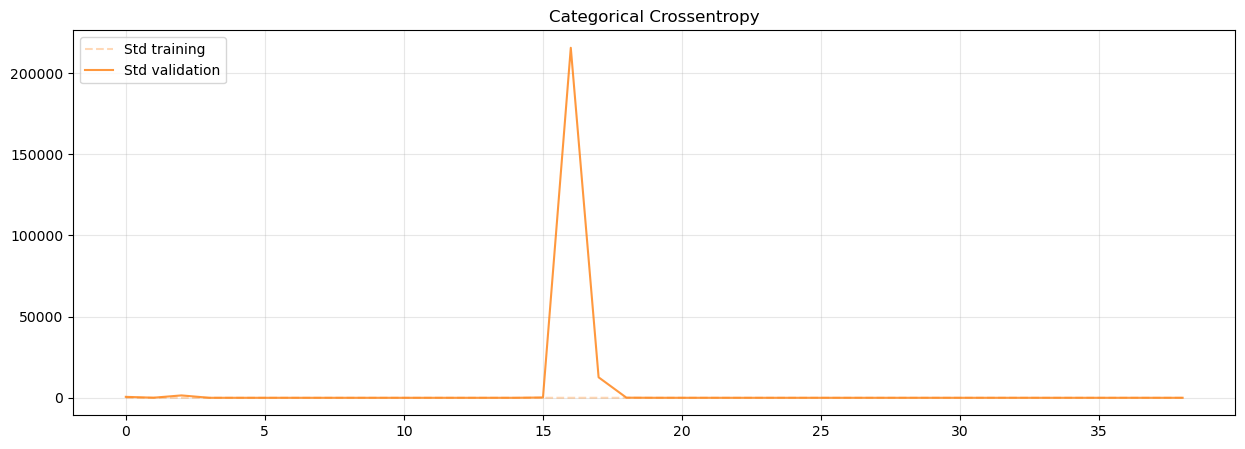

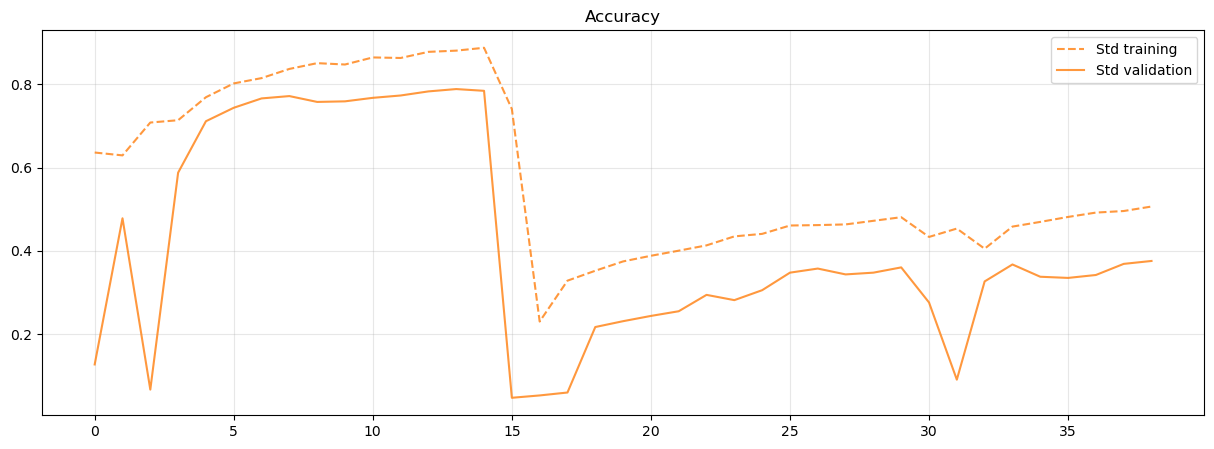

In [ ]:
history = classifier_history

plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

23/23 [==============================] - 7s 100ms/step
Accuracy: 0.7882
Precision: 0.7816
Recall: 0.7128
F1: [0.24   0.7897 0.8041 0.7965 0.8522 0.6154 0.8636 0.798 ]


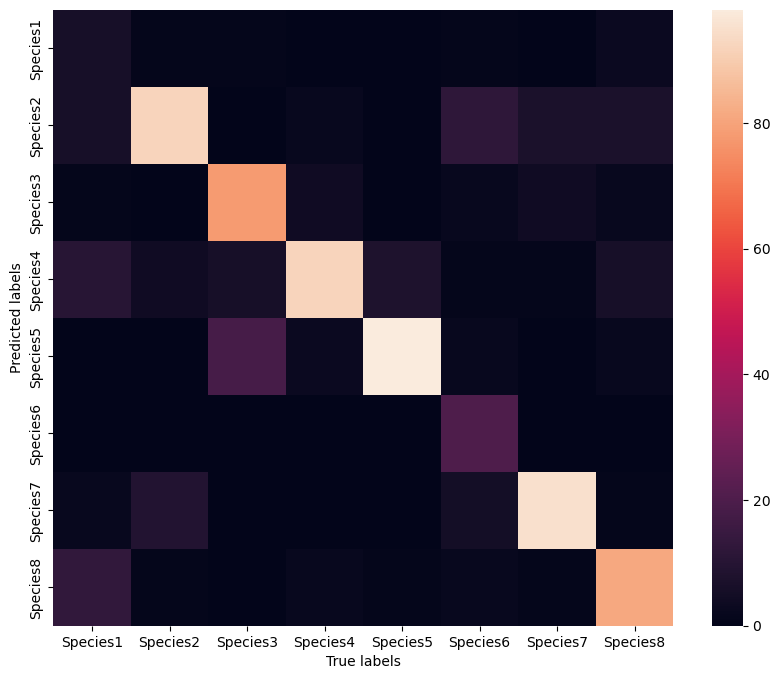

In [ ]:
predictions = classifier_model.predict(valid_dataset, steps=len(valid_gen))
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average=None)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=classes, yticklabels=classes)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [ ]:
best_loss, best_acc = model.evaluate(valid_dataset, steps=len(valid_gen), verbose=2)
loss, acc = classifier_model.evaluate(valid_dataset, steps=len(valid_gen), verbose=2)
if acc > best_acc:
    print("Model improved!")
    classifier_model.save('best_model')
else:
    print("No improvement!")

23/23 - 4s - loss: 0.4838 - accuracy: 0.8415 - 4s/epoch - 191ms/step
23/23 - 2s - loss: 0.7025 - accuracy: 0.7882 - 2s/epoch - 106ms/step
No improvement!


### Zip the model

In [ ]:
shutil.make_archive('best_model', 'zip', 'best_model')
shutil.rmtree('best_model')